# Geradores

## $ \pi^*$

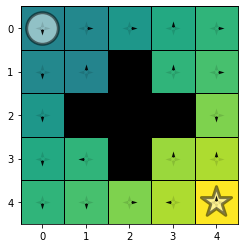

In [1]:
import numpy as np
from grid import Grid
from plot import plotPolicy, plotStateValue, plotActionStateValue, plotEffects, plotTrajectory

g = Grid()
g.pi_star()
# g.q_star()

ax = plotEffects(g)
plotPolicy(g.PI, g, ax=ax)
plotActionStateValue(g.Q, g, ax=ax)
# np.array([sum(q) for q in g.Q]).reshape(*g.size)
# g.PI
pi_star = g.PI

## $ h_1 $ 


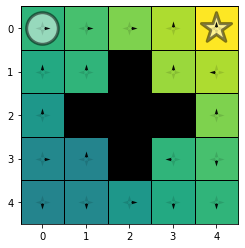

In [2]:
h1 = Grid()
target_1 = 4
h1.effects[(4,4)] = {'noise': lambda a: [-a[0], -a[1]]}
h1.effects[h1.S[target_1]] = {'terminal': True, 'reward': 10}

h1.pi_star()

ax = plotEffects(h1)
plotPolicy(h1.PI, h1, ax=ax)
plotActionStateValue(h1.Q, h1, ax=ax)

pi_1 = h1.PI

## $ h_2 $ 

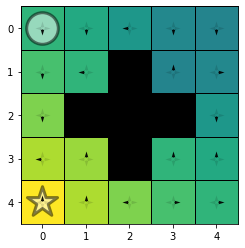

In [3]:
h2 = Grid()

target_2 = 20
h2.effects[(4,4)] = {'noise': lambda a: [-a[0], -a[1]]}
h2.effects[h2.S[target_2]] = {'terminal': True, 'reward': 10}

h2.pi_star()

ax = plotEffects(h2)
plotPolicy(h2.PI, h2, ax=ax)
plotActionStateValue(h2.Q, h2, ax=ax)

pi_2 = h2.PI

## $ \xi $

<AxesSubplot: >

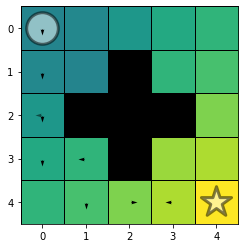

In [4]:
import random
def generateTrajetory(pi, g, size=10):
    s = 0

    arr = []
    for _ in range(size-1):
        a  = random.choices(list(range(len(g.A))), pi[s], k=1)[0]
        step =  (s, a)
        s,_,_ = g.transition(s,  a)
        arr.append(step)
    arr.append((s, None))

    return arr

trajectory_pi_star = generateTrajetory(pi_star, g, 10)

ax = plotEffects(g)
# plotPolicy(h_2.PI, h_2, ax=ax)
plotTrajectory(trajectory_pi_star, g, ax=ax)
plotActionStateValue(g.Q, g, ax=ax)


# Estimadores

## Likelihood

### Glossário
$\xi$ : Trajetória (sequencia de estados e ações) <br>
$\mathcal{H}$ : Conjunto de Options <br>
$\psi_h(s) \in [0,1]$ : Politica de termino (Probabilidade de Término da option $h$ no estado $s$) <br>
$\eta(h|s) $ : Politica Superior (Probabilidade de estar na option $h$ dado o estado $s$)<br>

$\xi = x_1^{10} $ com $ x_i = (s,a) $ para $ s_0 = 0, s_i = p(s_i|s_{i-1}, a_{i-1}) $ e $ a_i = \pi^*(s_i)$ <br>
$\psi_h(s) = \{_{0, \; s \ne s^{t_h}}^{1, \; s = s^{t_h} } $ para $ s^{t_h}=$ Estado $s$ objetivo para $\pi_h$ <br>
$\mathcal{H} = h_1^2 $ com $ h_i = (\pi_i, \psi_i)$ <br>
$\eta(h|s) = \frac{\sum_{a} q_h(a, s)}{\sum_{h}\sum_{a} q_h(a, s)}$

eta -> distribuição de boltzman (softmax)

In [5]:
pH = [
    lambda s: 0 if sum(h1.Q[s]) + sum(h2.Q[s]) == 0 else sum(h1.Q[s]) / (sum(h1.Q[s]) + sum(h2.Q[s])),
    lambda s: 0 if sum(h1.Q[s]) + sum(h2.Q[s]) == 0 else sum(h2.Q[s]) / (sum(h1.Q[s]) + sum(h2.Q[s])),
]

In [6]:
E = generateTrajetory(pi_star, g)
psi_1 = [int(s==target_1) for s,_ in enumerate(g.S)]
psi_2 = [int(s==target_2) for s,_ in enumerate(g.S)]
H = [
    (pi_1, psi_1),
    (pi_2, psi_2)
]
eta = np.array([[pH[h](s) for h,_ in enumerate(H)] for s,_ in enumerate(g.S)])

### Trajectory Prefix

$ \phi_0(h) = p_0(s_0)\eta(h|s_0) $
<br>

$\phi_{t+1}(h') = \sum_{h \in \mathcal{H}} \lgroup \phi_t(h)\pi_h(a_t|s_t) p(s_{t+1}|s_t, a_t) \psi_h(s_{t+1}) \rgroup \;\; \eta(h'|s_{t+1}) + \phi_t(h') \pi_{h'}(a_t|s_t) p(s_{t+1} | s_t, a_t) (1-\psi_{h'}(s_{t+1})) $

<br>
Modificação: <br>

$ \phi_t(h) = \sum_{h' \in \mathcal{H}} \lgroup \phi_{t-1}(h')\pi_{h'}(a_{t-1}|s_{t-1}) p(s_t|s_{t-1}, a_{t-1}) \psi_{h'}(s_t) \rgroup \;\; \eta(h|s_t) + \phi_{t-1}(h) \pi_{h}(a_{t-1}|s_{t-1}) p(s_t | s_{t-1}, a_{t-1}) (1-\psi_{h}(s_t)) $

#### Algoritmo de Programação Dinâmica:
```algorithm
calcula_Phi (t, h)
    se não existe t em phi[h]
        se não existe t-1 em phi[h]
            para cada h_ em H
                phi[h_, t-1] <-  calcula_Phi(h_, t-1)
        phi[h, t] <- PHIt+1(h)  
    devolva phi[h, t]
```

In [7]:
def prefix_likelihood(h,t, E,H):
    def __phi(t,h, E,H):
        s,_ = E[t]
        if t==0:
            return eta[s, h]
        
        s_,a_ = E[t-1]
        pi, psi = H[h]

        term_1 = sum(phi_table[h_][t-1] * pi_[s_][a_] * psi_[s] for h_,(pi_, psi_) in enumerate(H)) * eta[s, h]
        term_2 = phi_table[h][t-1] * pi[s_][a_] * (1-psi[s])

        return term_1 + term_2 

    phi_table = [{0: __phi(0,h, E,H)} for h,_ in enumerate(H)]

    def prefix(h,t, E,H):
        if t not in phi_table[h]:
            if t-1 not in phi_table[h]:
                for h_, _ in enumerate(H):
                    phi_table[h_][t-1] = prefix_likelihood(h_,t-1, E,H)
            phi_table[h][t] = __phi(t,h, E,H)
        return phi_table[h][t]
    return prefix(h,t, E,H)

### Trajectory Suffix

$\omega_{T-1}(h) = \pi_h(a_{T-1}|s_{T-1}) p(s_T | s_{T-1}, a_{T-1}) $
<br>
$\omega_t(h) = \pi_h(a_t|s_t) p(s_{t+1} | s_t, a_t) \lgroup \psi_h(s_{t+1}) \sum_{h' \in \mathcal{H}} \eta(h'|s_{t+1})\omega_{t+1}(h') + (1- \psi_h(s_{t+1})) \omega_{t+1}(h) \rgroup $

#### Algoritmo de Programação Dinâmica: 
```algorithm
calcula_W (t, h)
    se não existe t em w[h]
        se não existe t+1 em w[h]
            para cada h_ em H
                w[h_, t+1] <-  calcula_W(h_, t+1)
        w[h, t] <- Wt(h)  
    devolva w[h, t]
```

In [8]:
def suffix_likelihood(h, t, E, H):
    def __omega(t,h, E,H):
        _s,_a = E[-2]
        pi, psi = H[h]
        
        if t==(len(E)-2):
            return pi[_s][_a]
        
        s,a = E[t]
        s_,_ = E[t+1]
        
        term_1 = psi[s_] * sum(eta[s_, h_] * w_table[h_][t+1] for h_,_ in enumerate(H))
        term_2 = (1- psi[s_]) * w_table[h][t+1]

        return pi[s][a] * (term_1 +  term_2)

    w_table = [{(len(E)-2): __omega((len(E)-2),h, E,H)} for h,_ in enumerate(H)]

    def suffix(h, t, E, H):
        if t not in w_table[h]:
            if t+1 not in w_table[h]:
                for h_, _ in enumerate(H):
                    w_table[h_][t+1] = suffix_likelihood(h_,t+1, E,H)
            w_table[h][t] = __omega(t,h, E,H)
        return w_table[h][t]
    return suffix(h, t, E, H)

### Target
$\mathbb{P}_{\theta}(\xi) = \sum_{h \in \mathcal{H}} \phi_t(h)\omega_t(h)$ 

In [9]:
def likelihood(t, E,H):
    phi = prefix_likelihood
    omega = suffix_likelihood

    v = [phi(h,t, E,H) * omega(h,t, E,H) for h,_ in enumerate(H)]
    return sum(v)

likelihood(0, E, H)

9.922409057617192e-11

In [10]:
[likelihood(t, E, H) for t,_ in enumerate(E) if t<(len(E)-1)] 

[9.922409057617192e-11,
 9.922409057617192e-11,
 9.922409057617192e-11,
 9.922409057617192e-11,
 9.922409057617192e-11,
 9.922409057617191e-11,
 9.922409057617191e-11,
 9.922409057617191e-11,
 9.922409057617191e-11]

In [11]:
T = 3
E = generateTrajetory(pi_star, g, size=T)
print(E)
[likelihood(t, E, H) for t in range(T-1)] 

[(0, 3), (0, 1), (5, None)]


[0.011875000000000002, 0.011875000000000002]

## Teste Manual
$ T = 2 $ <br>
$ \mathcal{H} = \{h_1, h_2\} $ <br> 
$ p_0(s_0) = 1 $ <br> 
$ p(s'|s,a) = 1 \;\;\;\;\; \forall \;  s', s \in S \;\;\;\; and \;\;\;\; \forall \; a \in A$ <br> 

$ \eta(h_1|s_0) = .25 \;\;\;\;\;       \eta(h_1|s_1) = .45 $ <br>
$ \eta(h_2|s_0) = .75 \;\;\;\;\;       \eta(h_2|s_1) = .55$ <br>
$ \pi_{h_1}(a_0|s_0) = .9 \;\;\;\;     \pi_{h_1}(a_1|s_1) = .85 $ <br>
$ \pi_{h_2}(a_0|s_0) = .1 \;\;\;\;     \pi_{h_2}(a_1|s_1) = .15 $ <br>
$ \psi_{h_1}(s_1) = .65 \;\;\;\;\;\;\; \psi_{h_1}(s_2) = .95 $ <br>
$ \psi_{h_2}(s_1) = .35 \;\;\;\;\;\;\; \psi_{h_2}(s_2) = .05 $ <br>


In [12]:
eta_h1_s0 = .25
eta_h1_s1 = .45
eta_h2_s0 = .75
eta_h2_s1 = .55
pi_h1_a0_s0 = .9
pi_h1_a1_s1 = .85
pi_h2_a0_s0 = .1
pi_h2_a1_s1 = .15
psi_h1_s1 = .65
psi_h1_s2 = .95
psi_h2_s1 = .35
psi_h2_s2 = .05

# Criando Estruturas do Framework
pi_h1 = np.array([[0,0,pi_h1_a0_s0,0], [0,0,pi_h1_a1_s1,0], [0,0,0,0]])
pi_h2 = np.array([[0,0,pi_h2_a0_s0,0], [0,0,pi_h2_a1_s1,0], [0,0,0,0]])
psi_h1 = [0, psi_h1_s1, psi_h1_s2]
psi_h2 = [0, psi_h2_s1, psi_h2_s2]
eta = np.array([[eta_h1_s0, eta_h2_s0], [eta_h1_s1, eta_h2_s1], [0, 0]])

E = [(0,2), (1,2), (2,None)]
H = [
    (pi_h1, psi_h1),
    (pi_h2, psi_h2)
]

# Resultados
print('\n phi_0_h0', 'omega_0_h0', 'phi_0_h1', 'omega_0_h1')
print(
    prefix_likelihood(0, 0,E,H), 
    suffix_likelihood(0, 0,E,H),
    prefix_likelihood(1, 0,E,H),
    suffix_likelihood(1, 0,E,H)
)
print('\n phi_1_h0', 'omega_1_h0', 'phi_1_h1', 'omega_1_h1')
print(
    prefix_likelihood(0, 1,E,H), 
    suffix_likelihood(0, 1,E,H),
    prefix_likelihood(1, 1,E,H),
    suffix_likelihood(1, 1,E,H)
)
print('\n likelihoods (t0, t1):')
print(likelihood(0, E, H), likelihood(1, E, H))


 phi_0_h0 omega_0_h0 phi_0_h1 omega_0_h1
0.25 0.539775 0.75 0.026025

 phi_1_h0 omega_1_h0 phi_1_h1 omega_1_h1
0.15637500000000001 0.85 0.14362500000000003 0.15

 likelihoods (t0, t1):
0.1544625 0.1544625


$ \mathbb{P}_\theta(x) = \phi_0(h_1) \omega_0(h_1) + \phi_0(h_2) \omega_0(h_2) = \phi_1(h_1) \omega_1(h_1) + \phi_1(h_2) \omega_1(h_2) $ <br>

$ \phi_0(h_1) = \eta(h_1|s_0) $ <br> 
$ \phi_0(h_2) = \eta(h_2|s_0) $ <br> 
$ \phi_1(h_1) = \eta(h_1|s_1)(\eta(h_1|s_0) \pi_{h_1}(a_0|s_0) \psi_{h_1}(s_1) + \eta(h_2|s_0) \pi_{h_2}(a_0|s_0) \psi_{h_2}(s_1)) + \eta(h_1|s_0) \pi_{h_1}(a_0|s_0) (1-\psi_{h_1}(s_1)) $ <br> 
$ \phi_1(h_2) = \eta(h_2|s_1)(\eta(h_1|s_0) \pi_{h_1}(a_0|s_0) \psi_{h_1}(s_1) + \eta(h_2|s_0) \pi_{h_2}(a_0|s_0) \psi_{h_2}(s_1)) + \eta(h_2|s_0) \pi_{h_2}(a_0|s_0) (1-\psi_{h_2}(s_1)) $ <br> 
$ \omega_0(h_1) = \pi_{h_1}(a_0|s_0) \lgroup \; \psi_{h_1}(s_1) (\eta(h_1|s_1) \pi_{h_1}(a_1|s_1) + \eta(h_2|s_1) \pi_{h_2}(a_1|s_1)) + (1-\psi_{h_1(s1)}) \pi_{h_1}(a_1|s_1) \; \rgroup $ <br> 
$ \omega_0(h_2) = \pi_{h_2}(a_0|s_0) \lgroup \; \psi_{h_2}(s_1) (\eta(h_1|s_1) \pi_{h_1}(a_1|s_1) + \eta(h_2|s_1) \pi_{h_2}(a_1|s_1)) + (1-\psi_{h_2(s1)}) \pi_{h_2}(a_1|s_1) \; \rgroup $ <br> 
$ \omega_1(h_1) = \pi_{h_1}(a_1|s_1)  $ <br> 
$ \omega_1(h_2) = \pi_{h_2}(a_1|s_1)  $ <br> 

In [13]:
phi_0_h1 = eta_h1_s0
phi_0_h2 = eta_h2_s0
phi_1_h1 = eta_h1_s1 * (eta_h1_s0 * pi_h1_a0_s0 * psi_h1_s1 + eta_h2_s0 * pi_h2_a0_s0 * psi_h2_s1) + eta_h1_s0 * pi_h1_a0_s0 * (1-psi_h1_s1)
phi_1_h2 = eta_h2_s1 * (eta_h1_s0 * pi_h1_a0_s0 * psi_h1_s1 + eta_h2_s0 * pi_h2_a0_s0 * psi_h2_s1) + eta_h2_s0 * pi_h2_a0_s0 * (1-psi_h2_s1)
omega_0_h1 = pi_h1_a0_s0 * (psi_h1_s1 * (eta_h1_s1 * pi_h1_a1_s1 + eta_h2_s1 * pi_h2_a1_s1) + (1-psi_h1_s1) * pi_h1_a1_s1)
omega_0_h2 = pi_h2_a0_s0 * (psi_h2_s1 * (eta_h1_s1 * pi_h1_a1_s1 + eta_h2_s1 * pi_h2_a1_s1) + (1-psi_h2_s1) * pi_h2_a1_s1)
omega_1_h1 = pi_h1_a1_s1
omega_1_h2 = pi_h2_a1_s1

print(phi_0_h1, omega_0_h1, phi_0_h2, omega_0_h2)
print(phi_1_h1, omega_1_h1, phi_1_h2, omega_1_h2)
print(phi_0_h1*omega_0_h1 + phi_0_h2*omega_0_h2, phi_1_h1*omega_1_h1 + phi_1_h2*omega_1_h2)

0.25 0.539775 0.75 0.026025
0.15637500000000001 0.85 0.14362500000000003 0.15
0.1544625 0.1544625


## Marginal Posteriors


$ u_{t}(h) = \frac{1}{\mathbb{P}(\xi)} \phi_t(h)\omega_t(h)$

In [14]:
def u(h, t, E, H):
    phi = prefix_likelihood
    omega = suffix_likelihood

    return 1/likelihood(t, E, H) * phi(h,t, E,H) * omega(h,t, E,H)
    

$ v_{0}(h) = u_0(h) $
<br><br>
$ v_{t+1}(h') = \frac{1}{\mathbb{P}(\xi)} \; \lgroup \; \sum_{h \in \mathcal{H}} \phi_t(h) \pi_h(a_t|s_t) p(s_{t+1}|s_t, a_t) \psi_h(s_{t+1}) \; \rgroup \; \eta(h'|s_{t+1}) \omega_{t+1}(h') $

In [15]:
def v(h, t, E, H):
    if t == 0:
        return u(h, t, E, H)

    s,a = E[t]
    s_,_ = E[t+1]

    phi = prefix_likelihood
    omega = suffix_likelihood

    somatoria = sum(phi(h,t, E,H) * pi[s][a] * psi[s_] for h,(pi, psi) in enumerate(H))

    return 1/likelihood(t, E, H) * somatoria * eta[s_, h] * omega(h,t+1, E,H)

$ w_t(h) = \frac{1}{\mathbb{P}(\xi)} \phi_t(h) \pi_h(a_t|s_t) p(s_{t+1} | s_t, a_t) (1-\psi_h(s_{t+1})) \omega_{t+1}(h) $

In [16]:
def w(h, t, E, H):
    phi = prefix_likelihood
    omega = suffix_likelihood

    s,a = E[t]
    s_,_ = E[t+1]
    pi, psi = H[h]

    return 1/likelihood(t, E, H) * phi(h,t, E,H) * pi[s][a] * (1-psi[s_]) * omega(h,t+1, E,H)

## Expectation Gradient

$ \nabla_{\theta}L[\theta;\xi] = \sum_{h \in \mathcal{H}} \; \lgroup \; \sum_{t=0}^{T-1} \;\lgroup\; v_t(h) \nabla_{\theta} log \eta(h|s_t) + u_t(h) \nabla_{\theta} log \pi_h(a_t|s_t)
\;\rgroup\; + \sum_{t=0}^{T-2} \;\lgroup\; (u_t(h) - w_t(h)) \nabla_{\theta} log \psi_h(s_{t+1}) + w_t(h) \nabla_{\theta} log (1-\psi_h(s_{t+1})) \;\rgroup\;\;\rgroup\; $ 

Sendo:<br><br>
$ \nabla_{\theta} log \eta(h|s_t) = \frac{\partial log \eta(h|s_t)}{\partial \theta} = \frac{1}{\eta(h|s_t)} \frac{\partial \eta(h|s_t)}{\partial \theta} =        $ <br><br>
$ \nabla_{\theta} log \pi_h(a_t|s_t) = \frac{\partial log \pi_h(a_t|s_t)}{\partial \theta} = \frac{1}{\pi_h(a_t|s_t)} \frac{\partial \pi_h(a_t|s_t)}{\partial \theta} =    $ <br><br>
$ \nabla_{\theta} log \psi_h(s_{t+1}) = \frac{\partial log \psi_h(s_{t+1})}{\partial \theta} = \frac{1}{\psi_h(s_{t+1})} \frac{\partial \psi_h(s_{t+1})}{\partial \theta} =      $ <br><br>
$ \nabla_{\theta} log (1-\psi_h(s_{t+1})) = \frac{\partial log (1-\psi_h(s_{t+1}))}{\partial \theta} = \frac{1}{1-\psi_h(s_{t+1})} (-\frac{\partial \psi_h(s_{t+1})}{\partial \theta}) =    $

<br><br>
$\pi_h(a_t|s_t) = \{^{1-\epsilon + \frac{\epsilon}{|A|} \: se \: a_t = a^*}_{\frac{\epsilon}{|A|}  \: se \: a_t \ne a^*} $ <br><br>
$ \frac{\partial \pi_h(a_t|s_t)}{\partial \theta} = \{^{-1 + \frac{1}{|A|} \: se \: a_t = a^*}_{\frac{1}{|A|}  \: se \: a_t \ne a^*} $



$ \eta(h|s) = \frac{v_h(s)}{\sum_{h'} v_{h'}(s)} $ <br><br>
$ \frac{\partial \eta(h|s_t)}{\partial \theta} = 0 $ 

$ \psi_h(s) = \frac{v_h(s)}{v_{h}(s^{t_h})} $ <br><br>
$ \frac{\partial \psi_h(s)}{\partial \theta} = 0 $

In [17]:
E = generateTrajetory(pi_star, g)
psi_1 = [(1e-3, 1-1e-3)[s==target_1] for s,_ in enumerate(g.S)]
psi_2 = [(1e-3, 1-1e-3)[s==target_2] for s,_ in enumerate(g.S)]
H = [
    (pi_1, psi_1),
    (pi_2, psi_2)
]
eta = np.array([[pH[h](s) for h,_ in enumerate(H)] for s,_ in enumerate(g.S)])

In [22]:
def expectation_gradient(E, H):
    derivada_pi = lambda s, a, pi: 1/pi[s][a] * (-1 + 1/len(pi[s])) if a == np.argmax(pi[s]) else 1/len(pi[s])
    derivada_eta = lambda s, h, eta: 0 #1/eta[s, h] * 1
    derivada_psi = lambda s, psi: 0 #1/psi[s] * 1

    term1 = lambda t,s,a,h,pi:  v(h, t, E, H) * derivada_eta(s,h,eta) + u(h, t, E, H) * derivada_pi(s,a,pi)
    term2 = lambda t,h,psi:  (u(h, t, E, H) - w(h, t, E, H)) * derivada_psi(E[t+1][0], psi) + w(h, t, E, H) * 1/(1 - derivada_psi(E[t+1][0], psi))

    sum_1 = lambda h, pi: sum(term1(t,s,a,h,pi) for t,(s,a) in enumerate(E) if t < (len(E)-2))
    sum_2 = lambda h, psi: sum(term2(t,h,psi) for t,_ in enumerate(E) if t < (len(E)-2))

    return sum(sum_1(h, pi) + sum_2(h, psi) for h,(pi, psi) in enumerate(H))

expectation_gradient(E, H)

3.8459300959459553